In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).\
    filter(measurement.date).order_by(measurement.date.desc()).first()
recent_date = str(recent_date[0])
first_date = recent_date
# Calculate the date one year from the last date in data set(moved to other cell for consistency)
recent_date = dt.strptime(recent_date, '%Y-%m-%d')
date_math = recent_date - relativedelta(years=1)
last_date = date_math.strftime('%Y-%m-%d')


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date, measurement.prcp).filter(measurement.date>last_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
perc_df = pd.DataFrame(result, columns= ['Date', 'Percipitation'])
perc_df = perc_df.dropna()

# Sort the dataframe by date
perc_df = perc_df.sort_values(['Date'], ascending=True).reset_index(drop=True)
perc_df.head()

,Date,Percipitation
0,2016-08-24,0.08
1,2016-08-24,1.22
2,2016-08-24,2.28
3,2016-08-24,1.45
4,2016-08-24,2.15


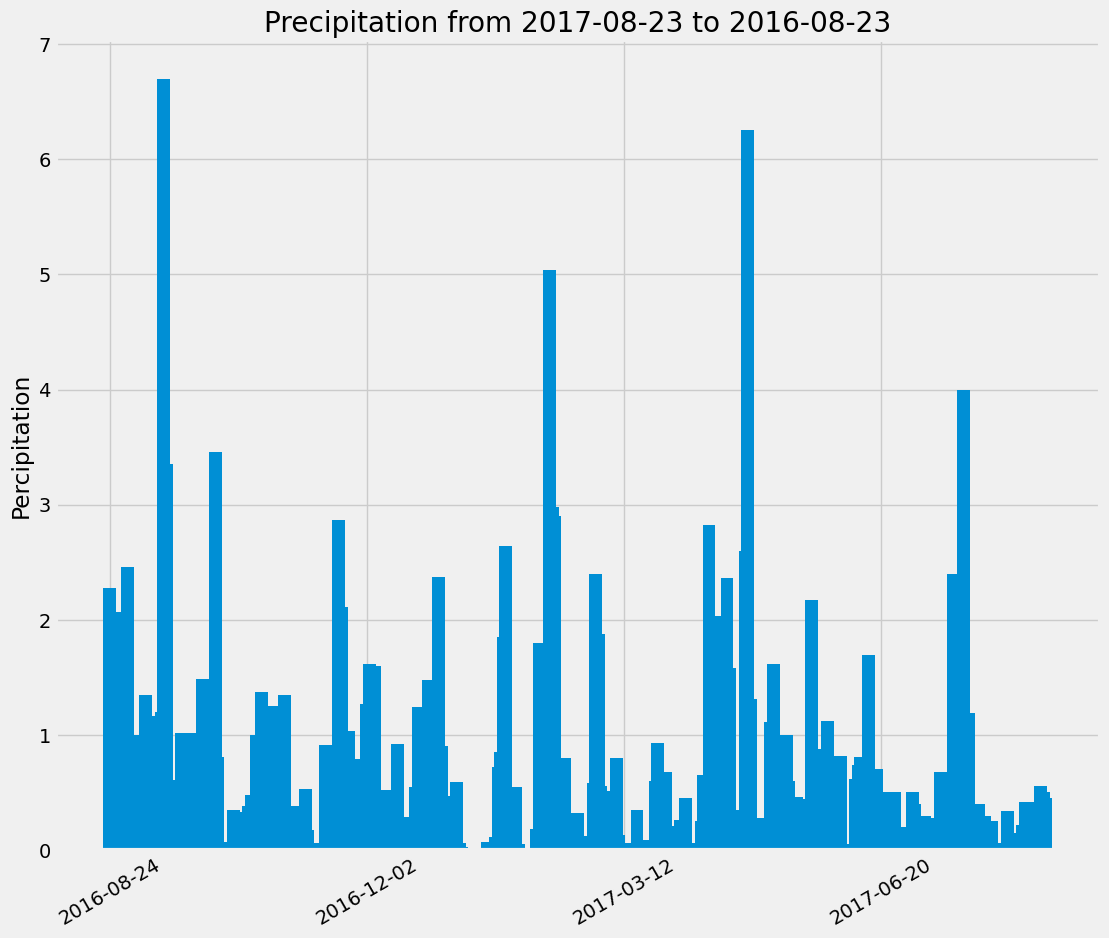

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data


x = perc_df['Date'].tolist()
y = perc_df['Percipitation'].tolist()


plt.figure(figsize=(12, 10))
plt.bar(x,y, width=5, align='center')
plt.title(f"Precipitation from {first_date} to {last_date}")
plt.ylabel('Percipitation')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.xticks(rotation=30)
plt.grid(which='major', axis='both', linestyle= '-')

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
perc_df.describe()

,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

stations = session.query(measurement.station,func.count(measurement.id)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

mas = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
mas

(54.0, 85.0, 71.66378066378067)

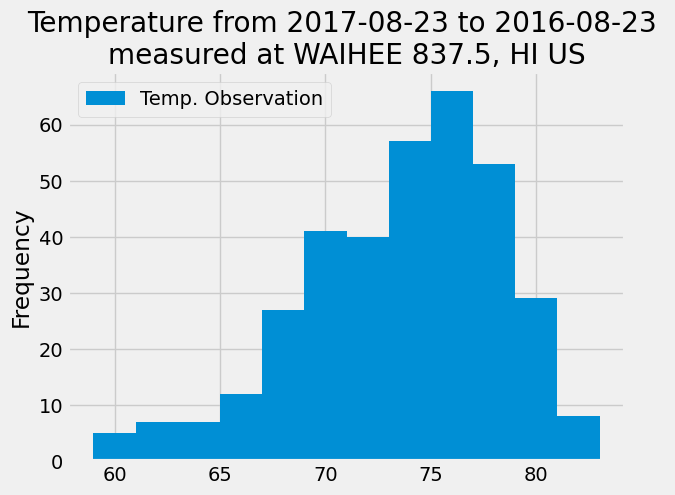

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result = session.query(measurement.tobs).\
    filter(measurement.station == stations[0][0]).\
    filter(measurement.date >= last_date).all()
temperatures = list(np.ravel(result))

result = session.query(station.station,station.name,station.latitude,station.longitude,station.elevation).all()
stations_df = pd.DataFrame(result, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_df.loc[stations_df["Station"] == stations[0][0],"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.5,label='Temp. Observation')
plt.grid(axis='both', alpha=1)
plt.ylabel('Frequency')
plt.title(f"Temperature from {first_date} to {last_date} \nmeasured at {stationname}")
plt.legend()

# Close Session

In [17]:
# Close Session
session.close()